In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# For Google Colab
# !nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-8ff2ddb5-97a6-8153-a43f-28a9c43ae82a)


In [3]:
import torch
torch.cuda.get_device_capability()

(7, 5)

In [4]:
tf.__version__

'2.17.1'

In [2]:
import os
from pathlib import Path

if Path("helper_fuctions.py").exists():
  print("File already exists no need to download :D .")
else:
  print("Downloading Files")
  !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2025-01-21 05:02:05--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-01-21 05:02:06 (100 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

In [4]:
import tensorflow_datasets as tfds
tfds.__version__

'4.9.7'

In [5]:
datasets_list = tfds.list_builders()

target_dataset = "food101"
print(f"{target_dataset} in TensorFlow's Datasets: {target_dataset in datasets_list}")

food101 in TensorFlow's Datasets: True


In [ ]:
(train_data, test_data), ds_info = tfds.load(target_dataset,
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

In [ ]:
# Load in the data (takes about 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101", # target dataset to get from TFDS
                                             split=["train", "validation"], # what splits of data should we get? note: not all datasets have train, valid, test
                                             shuffle_files=True, # shuffle files on download?
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True) # include dataset metadata? if so, tfds.load() returns tuple (data, ds_info)

In [13]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [14]:
class_names = ds_info.features["label"].names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [15]:
len(class_names)

101

In [16]:
train_sample = train_data.take(1)
train_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

Image Shape: (384, 512, 3)
Label: 70
Label in string foramt: pad_thai


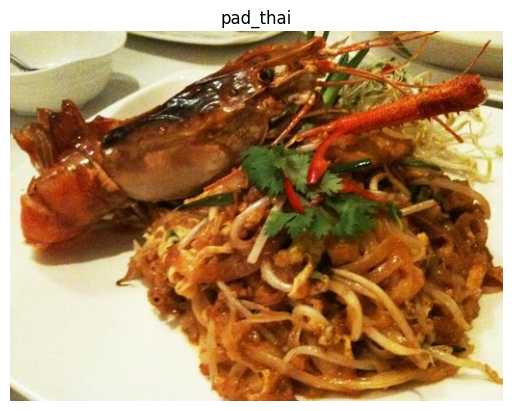

In [31]:
for image, label in train_sample:
  print(f"Image Shape: {image.shape}")
  print(f"Label: {label.numpy()}")
  print(f"Label in string foramt: {class_names[label.numpy()]}")

import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to image by indexing on class_names list
plt.axis(False);

In [35]:
def preprocess_img(image, label, img_shape=224):

  image = tf.image.resize(image, [img_shape, img_shape])

  return tf.cast(image, tf.float32), label

In [42]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[230 229 183]
  [231 230 184]
  [232 231 183]
  ...
  [232 233 202]
  [229 234 204]
  [229 236 205]]

 [[228 227 179]
  [227 226 178]
  [226 226 176]
  ...
  [234 235 204]
  [232 237 207]
  [234 241 210]]]...,
Shape: (384, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[229.46939 228.46939 181.7551 ]
  [229.59184 228.94897 180.2347 ]
  [224.14796 224.14796 171.71939]
  ...
  [238.21933 231.07143 200.37251]
  [237.02545 233.38266 204.23978]
  [230.32655 236.04091 205.68373]]

 [[228.80103 228.87245 174.58673]
  [225.95409 225.95918 173.80103]
  [226.64795 226.64795 174.21939]
  ...
  [238.41322 232.41322 199.95409]
  [235.8571  233.14287 202.07143]
  [233.04602 238.76038 206.4032 ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


In [40]:
preprocessed_img = preprocess_img(image, label)
len(preprocessed_img)

2

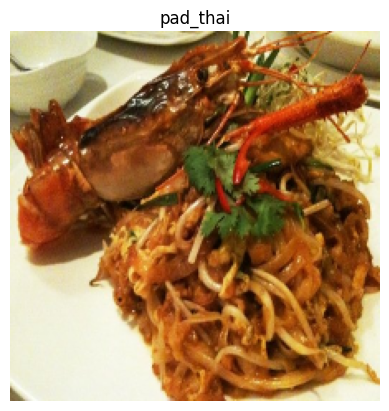

In [43]:
# We can still plot our preprocessed image as long as we
# divide by 255 (for matplotlib capatibility)
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

In [50]:
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

test_data = test_data.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [51]:
from helper_functions import create_tensorboard_callback

checkpoint_path = "model_checkpoints/cp.weights.h5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_weights_only=True,
                                                      save_best_only=True,
                                                      monitor="val_accuracy",
                                                      verbose=0)

In [52]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")

In [53]:
mixed_precision.global_policy()

<DTypePolicy "mixed_float16">

In [55]:
from tensorflow.keras import layers

input_shape = (224, 224, 3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

inputs = layers.Input(input_shape, name="input_layer")

x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="output_layer")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])

In [56]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, 7, 7, 1280)          │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pooling_layer                        │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 101)                 │         129,381 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_2 (Cast)                        │ (None, 101)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Activation)            │ (None, 101)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,048,693 (23.07 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [58]:
for layer in model.layers:
  print(f"Layer Name: {layer.name} | Trainable : {layer.trainable} | Dtype : {layer.dtype}  | Layer Dtype policy : {layer.dtype_policy}")

Layer Name: input_layer | Trainable : True | Dtype : float32  | Layer Dtype policy : <DTypePolicy "mixed_float16">
Layer Name: efficientnetv2-b0 | Trainable : False | Dtype : float32  | Layer Dtype policy : <DTypePolicy "mixed_float16">
Layer Name: pooling_layer | Trainable : True | Dtype : float32  | Layer Dtype policy : <DTypePolicy "mixed_float16">
Layer Name: dense | Trainable : True | Dtype : float32  | Layer Dtype policy : <DTypePolicy "mixed_float16">
Layer Name: output_layer | Trainable : True | Dtype : float32  | Layer Dtype policy : <DTypePolicy "float32">


In [59]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]: # only check the first 20 layers to save output space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer_1 False float32 <DTypePolicy "mixed_float16">
rescaling_1 False float32 <DTypePolicy "mixed_float16">
normalization_1 False float32 <DTypePolicy "mixed_float16">
stem_conv False float32 <DTypePolicy "mixed_float16">
stem_bn False float32 <DTypePolicy "mixed_float16">
stem_activation False float32 <DTypePolicy "mixed_float16">
block1a_project_conv False float32 <DTypePolicy "mixed_float16">
block1a_project_bn False float32 <DTypePolicy "mixed_float16">
block1a_project_activation False float32 <DTypePolicy "mixed_float16">
block2a_expand_conv False float32 <DTypePolicy "mixed_float16">
block2a_expand_bn False float32 <DTypePolicy "mixed_float16">
block2a_expand_activation False float32 <DTypePolicy "mixed_float16">
block2a_project_conv False float32 <DTypePolicy "mixed_float16">
block2a_project_bn False float32 <DTypePolicy "mixed_float16">
block2b_expand_conv False float32 <DTypePolicy "mixed_float16">
block2b_expand_bn False float32 <DTypePolicy "mixed_float16">
block2b_exp

In [71]:
tf.get_logger().setLevel("ERROR")

history_food_101_feature_extract = model.fit(train_data,
                                             epochs=3,
                                             steps_per_epoch=len(train_data) - 1,
                                             validation_data=test_data,
                                             validation_steps=int(0.15 * len(test_data)),
                                             callbacks=[create_tensorboard_callback("training_logs",
                                                                                    "efficientnetv2b0_101_classes_all_data_feature_extract"),
                                                        model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetv2b0_101_classes_all_data_feature_extract/20250121-065109
Epoch 1/3
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 213s 77ms/step - accuracy: 0.4626 - loss: 2.3470 - val_accuracy: 0.6965 - val_loss: 1.1691
Epoch 2/3
   1/2367 ━━━━━━━━━━━━━━━━━━━━ 9:29:19 14s/step - accuracy: 0.3333 - loss: 1.6975

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2367/2367 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.3333 - loss: 1.6975 - val_accuracy: 0.6843 - val_loss: 1.1883
Epoch 3/3
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 219s 74ms/step - accuracy: 0.6556 - loss: 1.3379 - val_accuracy: 0.7129 - val_loss: 1.0416


In [68]:
(len(train_data))

2367

In [65]:
(75 * (101 * 1000))/ 100

75750.0

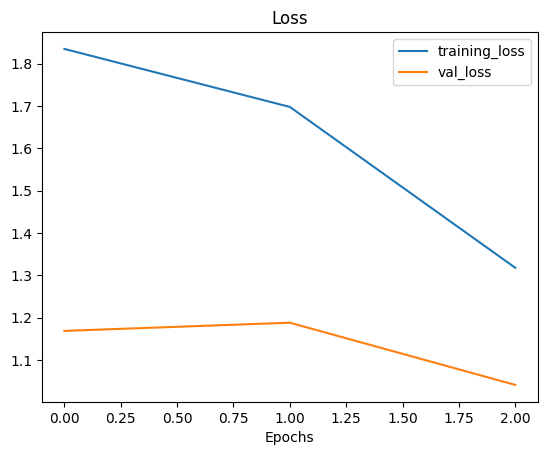

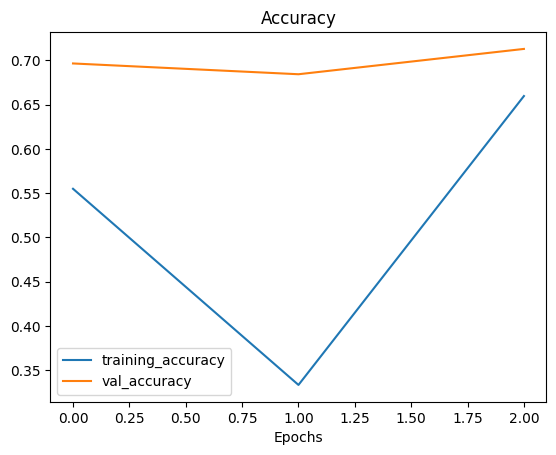

In [72]:
plot_loss_curves(history_food_101_feature_extract)

In [80]:
results_feture_extract = model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 53s 67ms/step - accuracy: 0.7158 - loss: 1.0559


In [78]:
def create_model(img_shape: int=(224, 224, 3)):

  base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
  base_model.trainable = False

  inputs = layers.Input(img_shape)
  x = base_model(inputs)
  x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
  x = layers.Dense(len(class_names))(x)
  outputs = layers.Activation("softmax", name="output_layer", dtype=tf.float32)(x)

  model = tf.keras.Model(inputs, outputs)


  return model

In [79]:
created_model = create_model()
created_model.compile(loss="sparse_categorical_crossentropy",
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=["accuracy"])

# 3. Load the saved weights
created_model.load_weights(checkpoint_path)

# 4. Evaluate the model with loaded weights
results_created_model_with_loaded_weights = created_model.evaluate(test_data)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 4 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


790/790 ━━━━━━━━━━━━━━━━━━━━ 63s 69ms/step - accuracy: 0.7163 - loss: 1.0549


In [81]:
assert np.isclose(results_created_model_with_loaded_weights, results_feture_extract).all(), "Loaded weights results are not close to original model."

In [82]:
# Check the layers in the base model and see what dtype policy they're using
for layer in created_model.layers[1].layers[:20]: # check only the first 20 layers to save printing space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer_6 False float32 <DTypePolicy "mixed_float16">
rescaling_4 False float32 <DTypePolicy "mixed_float16">
normalization_4 False float32 <DTypePolicy "mixed_float16">
stem_conv False float32 <DTypePolicy "mixed_float16">
stem_bn False float32 <DTypePolicy "mixed_float16">
stem_activation False float32 <DTypePolicy "mixed_float16">
block1a_project_conv False float32 <DTypePolicy "mixed_float16">
block1a_project_bn False float32 <DTypePolicy "mixed_float16">
block1a_project_activation False float32 <DTypePolicy "mixed_float16">
block2a_expand_conv False float32 <DTypePolicy "mixed_float16">
block2a_expand_bn False float32 <DTypePolicy "mixed_float16">
block2a_expand_activation False float32 <DTypePolicy "mixed_float16">
block2a_project_conv False float32 <DTypePolicy "mixed_float16">
block2a_project_bn False float32 <DTypePolicy "mixed_float16">
block2b_expand_conv False float32 <DTypePolicy "mixed_float16">
block2b_expand_bn False float32 <DTypePolicy "mixed_float16">
block2b_exp

In [87]:
from pathlib import Path

save_dir = Path("foodvision") #Path to save the model
save_dir.mkdir(parents=True, exist_ok=True)

save_path = save_dir / "FoodVisionFE.keras"
model.save(save_path)

In [88]:
load_model = tf.keras.models.load_model(save_path)

In [90]:
# Check the layers in the base model and see what dtype policy they're using
for layer in load_model.layers[1].layers[:20]: # check only the first 20 layers to save output space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer_1 True float32 <DTypePolicy "mixed_float16">
rescaling_1 False float32 <DTypePolicy "mixed_float16">
normalization_1 False float32 <DTypePolicy "mixed_float16">
stem_conv False float32 <DTypePolicy "mixed_float16">
stem_bn False float32 <DTypePolicy "mixed_float16">
stem_activation False float32 <DTypePolicy "mixed_float16">
block1a_project_conv False float32 <DTypePolicy "mixed_float16">
block1a_project_bn False float32 <DTypePolicy "mixed_float16">
block1a_project_activation False float32 <DTypePolicy "mixed_float16">
block2a_expand_conv False float32 <DTypePolicy "mixed_float16">
block2a_expand_bn False float32 <DTypePolicy "mixed_float16">
block2a_expand_activation False float32 <DTypePolicy "mixed_float16">
block2a_project_conv False float32 <DTypePolicy "mixed_float16">
block2a_project_bn False float32 <DTypePolicy "mixed_float16">
block2b_expand_conv False float32 <DTypePolicy "mixed_float16">
block2b_expand_bn False float32 <DTypePolicy "mixed_float16">
block2b_expa

In [92]:
results_loaded_model = load_model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 53s 67ms/step - accuracy: 0.7161 - loss: 1.0554


In [93]:
import shutil

#For copying the model from google colab to drive requries to mount drive
shutil.copy("/content/model_checkpoints/cp.weights.h5", save_dir)

'/content/drive/MyDrive/foodvision/cp.weights.h5'

In [94]:
assert np.isclose(results_loaded_model, results_feture_extract).all(), "The Weights are not close maybe there is a problem"